<a href="https://colab.research.google.com/github/minsing-jin/Dacon_Jeju/blob/main/EDA_dacon_jeju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd "/content/drive/My Drive/dacon_jeju"; ls -l

total 1021484
-rw------- 1 root root   8847328 Oct 20 11:30 4.1350782688_submit_cbr.csv
-rw------- 1 root root   8842466 Oct 19 14:34 5.0306451151_submit_xgb_lgb_cbr.csv
-rw------- 1 root root       778 Oct 17 13:59 data_info.csv
-rw------- 1 root root   4077384 Oct 17 13:59 sample_submission.csv
-rw------- 1 root root   8843638 Oct 21 13:13 submit_ensemble_cbr_lgb.csv
-rw------- 1 root root   8847609 Oct 23 08:24 submit_ensemble_cbr_tuning.csv
-rw------- 1 root root   8846049 Oct 23 13:48 submit_ensemble_rfr_cbr1.csv
-rw------- 1 root root   8847609 Oct 23 08:24 submit_ensemble_rfr.csv
-rw------- 1 root root   8819092 Oct 17 14:59 submit_test2.csv
-rw------- 1 root root   8844102 Oct 17 14:51 submit_test.csv
-rw------- 1 root root   8841356 Oct 19 14:18 submit_test_ensemble.csv
-rw------- 1 root root   6308536 Oct 19 14:25 submit_xgb.csv
-rw------- 1 root root  54131261 Oct 17 13:59 test.csv
-rw------- 1 root root 901898382 Oct 17 13:59 train.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
import xgboost
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor ## import libraries
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

%matplotlib inline

# Use MAE!
from sklearn.metrics import mean_absolute_error

# cross validation module
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold

In [ ]:
train = pd.read_csv('/content/drive/My Drive/dacon_jeju/train.csv')
test = pd.read_csv('/content/drive/My Drive/dacon_jeju/test.csv')
df_info = pd.read_csv('/content/drive/My Drive/dacon_jeju/data_info.csv')

In [ ]:
df_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,0.0,32400.0,0.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0.0,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0.0,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0.0,0.0,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0.0,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [ ]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,0.0,0.0,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,0.0,0.0,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,0.0,0.0,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,0.0,0.0,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,0.0,0.0,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


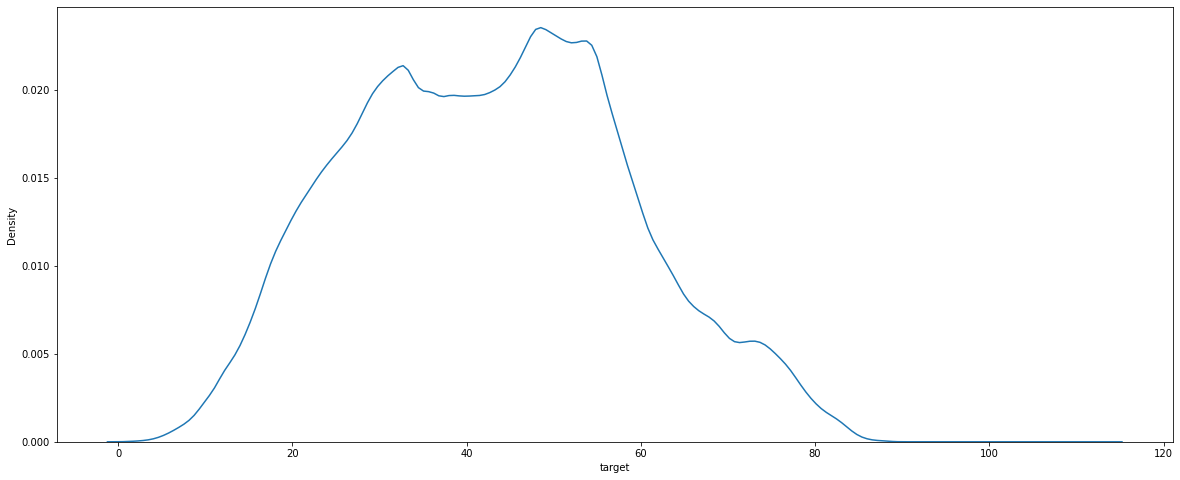

In [ ]:
plt.figure(figsize=(20,8))
sns.kdeplot(x = train.target)

In [ ]:
plt.figure(figsize=(20,8))
sns.kdeplot(x = test.target)

target의 분포는 주로 20-60에 분포해 있는걸 볼 수 있다.

In [ ]:
sns.pairplot(train, hue = "target")

In [ ]:
plt.show()


In [ ]:
train['target'].unique()

array([ 52.,  30.,  61.,  20.,  38.,  28.,  39.,  14.,  47.,  40.,  60.,
        58.,  32.,  35.,  50.,  56.,  46.,  21.,  70.,  37.,  33.,  54.,
        31.,  49.,  59.,  75.,  36.,  26.,  24.,  10.,  22.,  53.,  45.,
        77.,  57.,  48.,  66.,  41.,  51.,  44.,  23.,  73.,  18.,  29.,
        62.,  43.,  55.,  74.,  25.,  19.,  78.,  65.,  17.,  64.,  27.,
        42.,  72.,  71.,  13.,  16.,  34.,  15.,  67.,  85.,   9.,  81.,
        11.,  82.,  63.,   7.,  76.,  69.,  80.,  68.,  12.,  84.,  88.,
        79.,  87.,   6.,  83.,   8.,   5.,  86.,   3.,   4.,   2.,   1.,
        96., 112.,  93.,  94.,  92.,  91.,  90.,  99.,  89.,  97.,  95.,
       113.,  98., 103.])

In [ ]:
train['base_date'].value_counts()

48.0     112044
49.0     110244
50.0     108822
54.0     108040
51.0     107347
          ...  
112.0         2
96.0          2
113.0         2
98.0          1
103.0         1
Name: target, Length: 102, dtype: int64

# Categorical Variable encoding

## Categorical Variable columns extract

In [ ]:
str_col = []
for i in train.columns:
  if train[i].dtypes == 'object':
    str_col.append(i)

## Nomianal VS Ordinal

In [ ]:
le = LabelEncoder()
le=le.fit(train['day_of_week'])
train['day_of_week']=le.transform(train['day_of_week'])
print(train['day_of_week'])

print(train['day_of_week'].unique()) # 빈도수에 따라 가중치 부여해보자
print(train['day_of_week'].value_counts())

0          1
1          1
2          4
3          0
4          6
          ..
4701212    1
4701213    1
4701214    3
4701215    2
4701216    6
Name: day_of_week, Length: 4701217, dtype: int64
[1 4 0 6 3 2 5]
0    684024
2    675583
1    674070
4    673632
5    669767
6    662498
3    661643
Name: day_of_week, dtype: int64


In [ ]:
le = LabelEncoder()
le=le.fit(test['day_of_week'])
test['day_of_week']=le.transform(test['day_of_week'])
print(test['day_of_week'])

print(test['day_of_week'].unique()) # 빈도수에 따라 가중치 부여해보자
print(test['day_of_week'].value_counts())

0         1
1         6
2         0
3         1
4         2
         ..
291236    5
291237    0
291238    0
291239    0
291240    0
Name: day_of_week, Length: 291241, dtype: int64
[1 6 0 2 3 4 5]
6    47452
2    46974
3    46405
0    38029
1    37983
5    37280
4    37118
Name: day_of_week, dtype: int64


요일은 고루 분포하는 것을 확인